In [55]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for furniture sales.

In [73]:
df = pd.read_excel("Global Superstore 2018.xlsx")
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data.

In [74]:
furniture['Order Date'].min()

Timestamp('2014-01-01 00:00:00')

In [75]:
furniture['Order Date'].max()

Timestamp('2017-12-31 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [76]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [77]:
furniture.isnull().sum()

Order Date        0
Market            0
Sales             0
Shipping Cost     0
Order Priority    0
dtype: int64

In [78]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [79]:
furniture.head()

,Order Date,Sales
0,2014-01-01,113.6700
1,2014-01-03,1960.8225
2,2014-01-04,1686.7000
3,2014-01-05,48.7800
4,2014-01-06,324.4500


## Indexing with time series data

In [80]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-01', '2014-01-03', '2014-01-04', '2014-01-05',
               '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-10',
               '2014-01-11', '2014-01-12',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Order Date', length=1331, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [81]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 sales data.

In [82]:
y['2017':]

Order Date
2017-01-01    2492.838239
2017-02-01    2508.818696
2017-03-01    3450.206981
2017-04-01    2351.695310
2017-05-01    3277.070130
2017-06-01    4861.539718
2017-07-01    2839.458793
2017-08-01    4510.137246
2017-09-01    5859.221423
2017-10-01    4356.705863
2017-11-01    5628.288940
2017-12-01    5725.612620
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

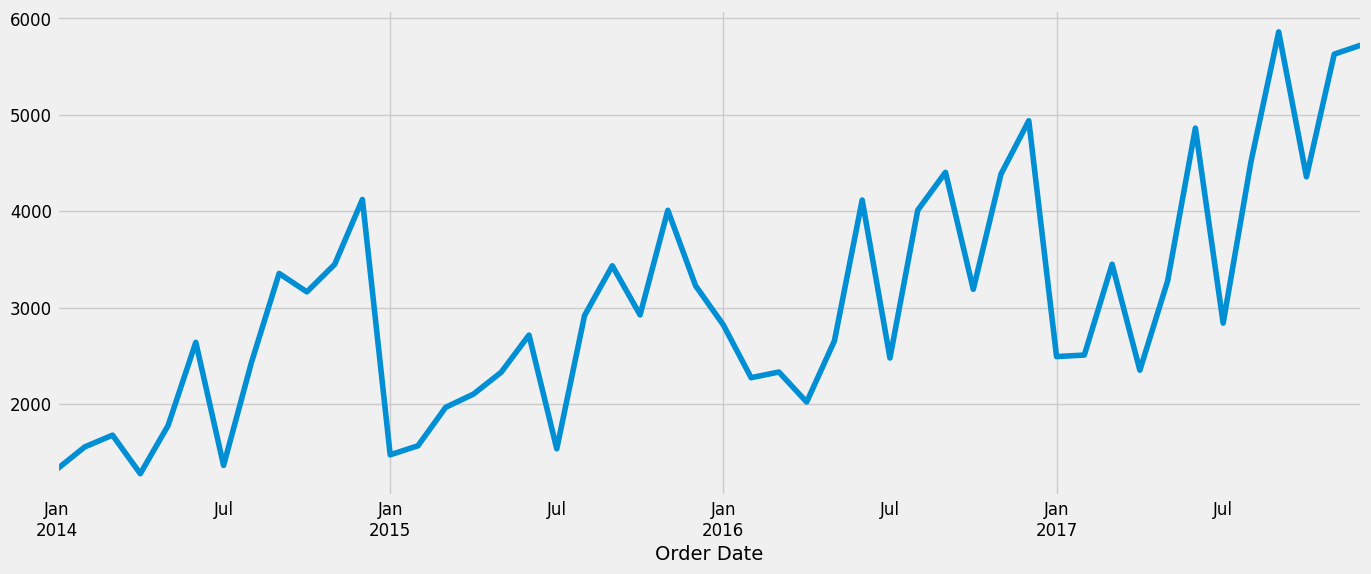

In [83]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

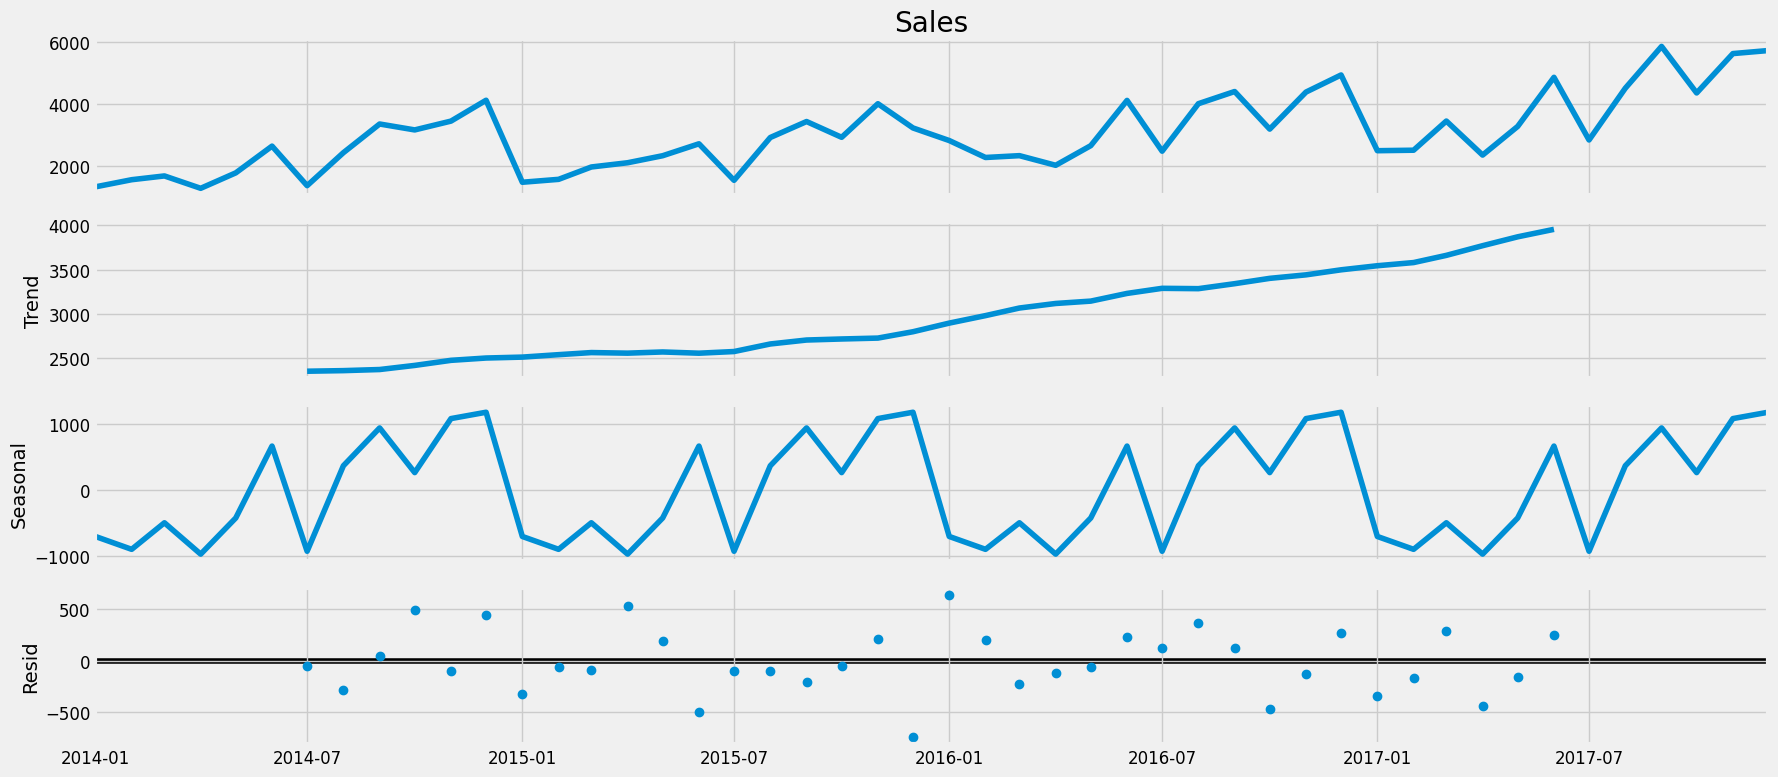

In [84]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [92]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [86]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:896.8626125722097
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1313.6288197246995
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:568.1100867120058
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:379.0332556018318
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:561.8279224155573
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1179.5400973705682
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:394.9835925793823
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:366.7440861092176
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:834.6620168328606
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2856.6539986335383
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:548.3428832247567
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:358.1727039502889
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:563.728150785798
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2472.414120368348
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:391.1968626432667
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:348.14276197789377
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:775.3333014965006
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:992.4307678437053
ARIMA(0

In [87]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0967      0.461      0.210      0.834      -0.807       1.001
ma.L1         -0.8112      0.292     -2.774      0.006      -1.384      -0.238
ar.S.L12      -0.4447      0.154     -2.880      0.004      -0.747      -0.142
sigma2      2.273e+05      9e+04      2.525      0.012    5.09e+04    4.04e+05


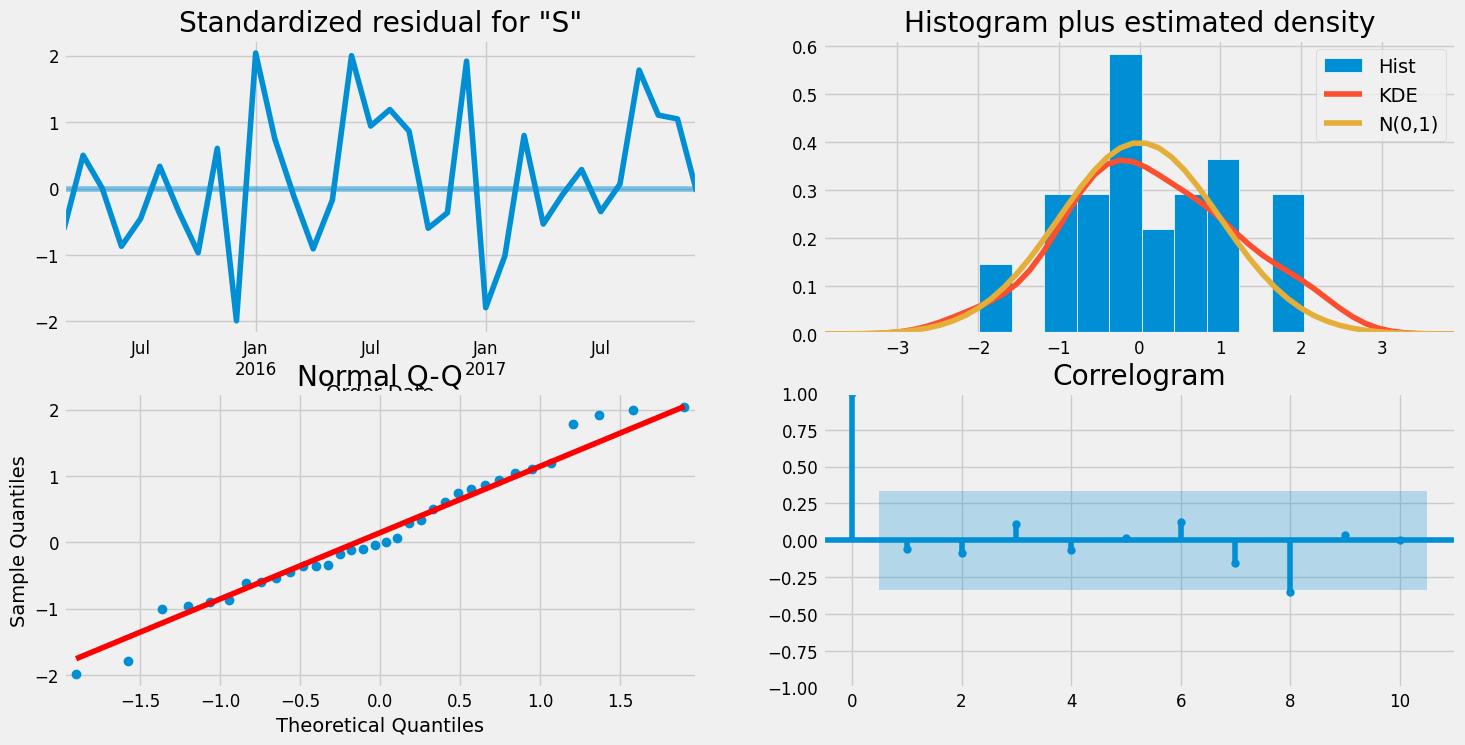

In [96]:
# Assuming 'y' is your dataset
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 6),  # Adjusted seasonal period
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results = mod.fit()

# Attempt to plot diagnostics if the dataset is large enough
try:
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
except ValueError as e:
    print("Error encountered: ", e)


## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

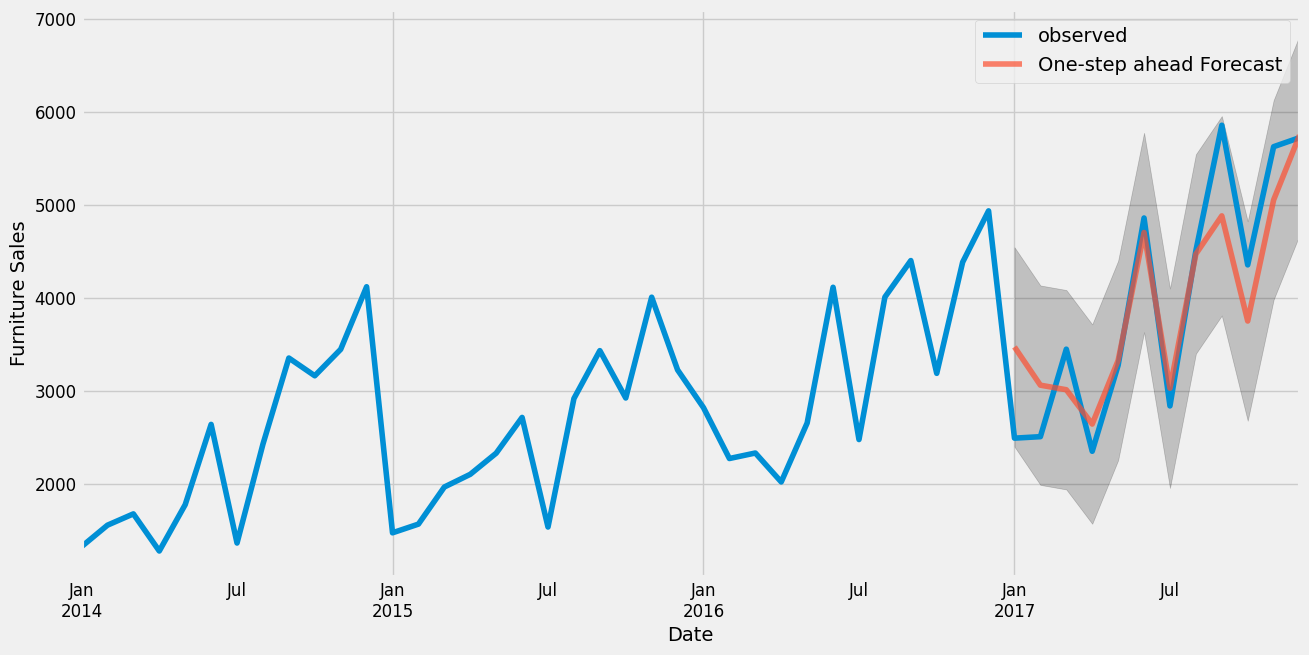

In [97]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [98]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 271154.23


In [99]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 520.72


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

## Producing and visualizing forecasts

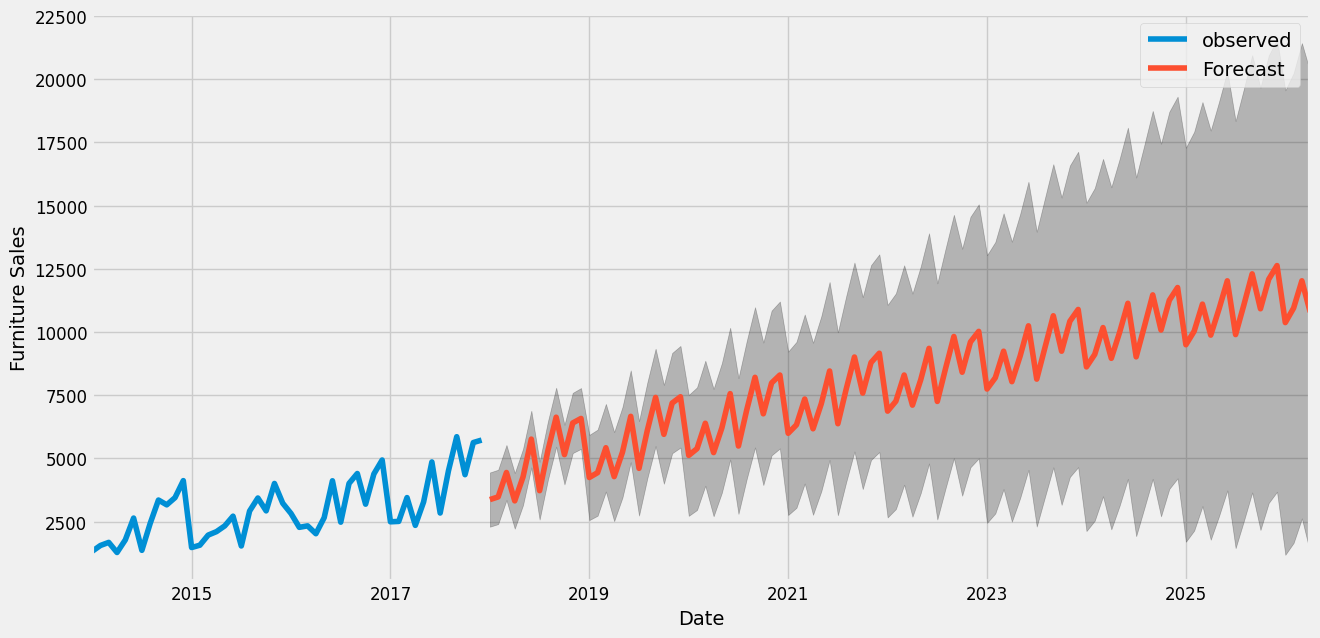

In [100]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other onver time. Therefore, we are going to compare time series of furniture and office supplier.

## Time Series comparison furniture sales and Office Supplies

### Data Preprocessing

In [101]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [102]:
furniture.shape, office.shape

((9860, 24), (31289, 24))

In [103]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

Have a quick peek, perfect!

In [104]:
furniture.head()

,Order Date,Sales
0,2014-01-01,113.6700
1,2014-01-03,1960.8225
2,2014-01-04,1686.7000
3,2014-01-05,48.7800
4,2014-01-06,324.4500


In [105]:
office.head()

,Order Date,Sales
0,2014-01-01,694.8930
1,2014-01-03,1172.8887
2,2014-01-04,696.2220
3,2014-01-05,3613.5300
4,2014-01-06,269.7681


### Data exploration

We are going to compare two categories' sales in the same time period. This means combine two data frames into one and plot these two categories' time series into one plot.

In [106]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,1325.528962,1156.094052
1,2014-02-01,1556.495109,1045.401172
2,2014-03-01,1678.219783,1088.915883
3,2014-04-01,1278.731046,1687.506181
4,2014-05-01,1777.452571,1776.123986


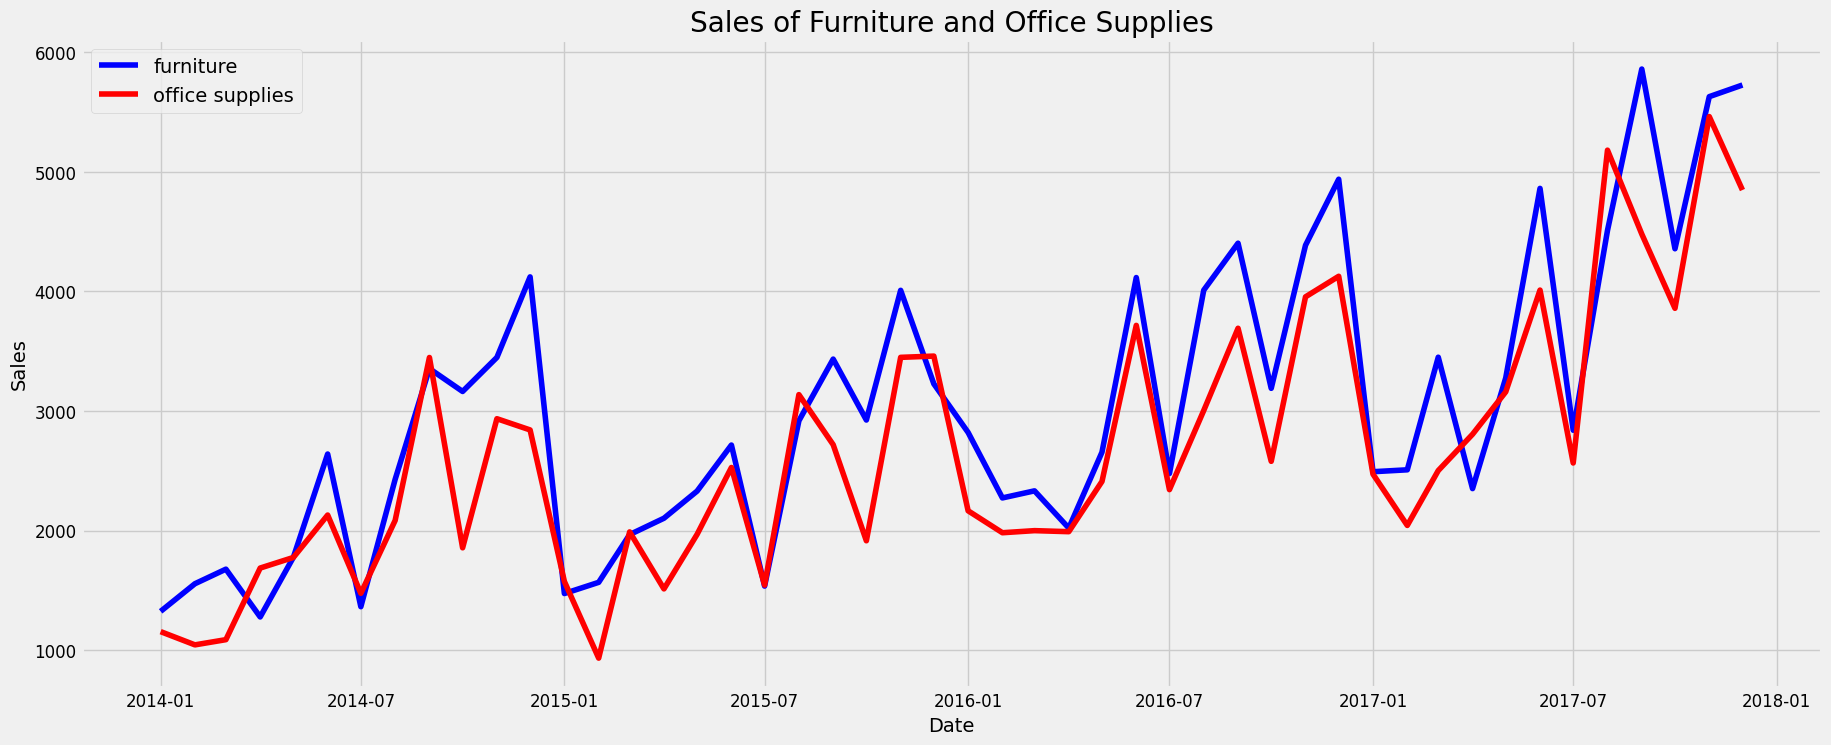

In [107]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occationaly, office supplies passed furnitue on average daily sales. Let's find out when was the first time office supplies' sales surpassed those of furniture's.

In [108]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-04-01.


It was July 2014.

### Time Series Modeling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [109]:
from prophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2d4fy5j/3votq7w_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2d4fy5j/o59xsaop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70523', 'data', 'file=/tmp/tmpf2d4fy5j/3votq7w_.json', 'init=/tmp/tmpf2d4fy5j/o59xsaop.json', 'output', 'file=/tmp/tmpf2d4fy5j/prophet_modelpztrfg0n/prophet_model-20240319195843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

In [110]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1800x600 with 0 Axes>

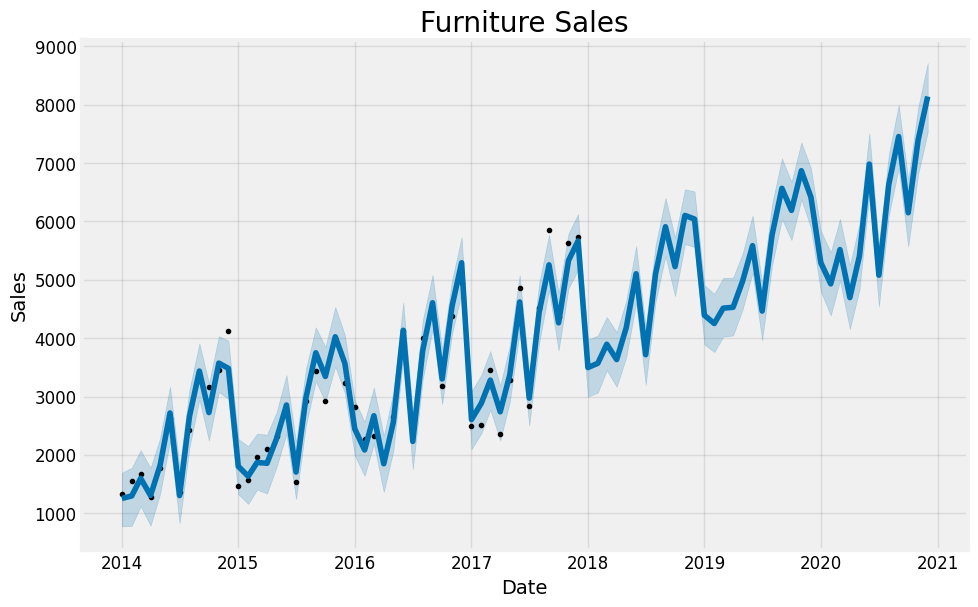

In [111]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1800x600 with 0 Axes>

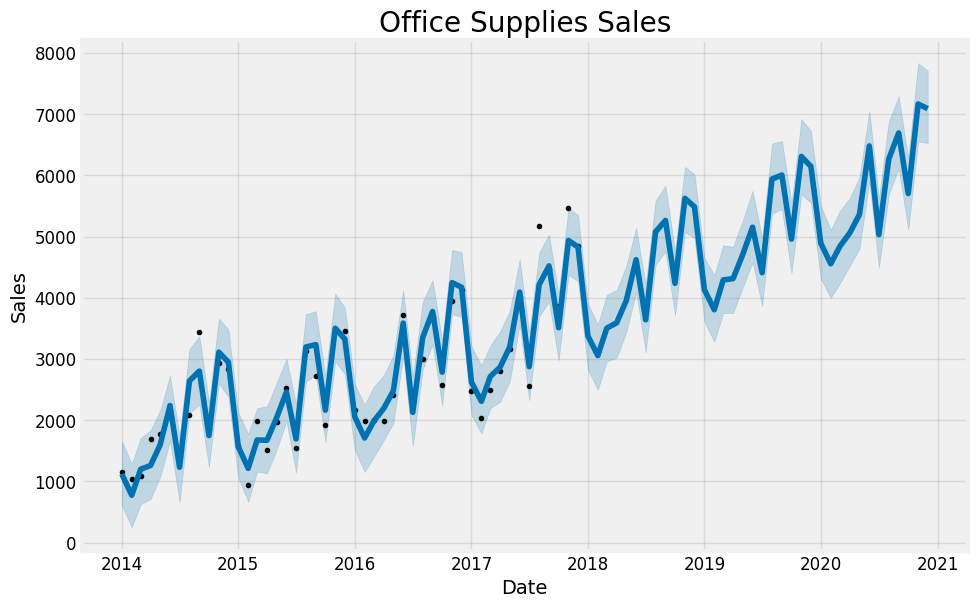

In [112]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

### Compare Forecasts

We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [113]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,2123.575198,776.543198,1696.079257,2123.575198,2123.575198,-868.414777,-868.414777,-868.414777,-868.414777,...,-566.789030,-566.789030,-566.789030,-566.789030,-566.789030,-566.789030,0.0,0.0,0.0,1121.425753
1,2014-02-01,2154.737816,785.606919,1780.857040,2154.737816,2154.737816,-855.554779,-855.554779,-855.554779,-855.554779,...,-949.133963,-949.133963,-949.133963,-949.133963,-949.133963,-949.133963,0.0,0.0,0.0,774.715648
2,2014-03-01,2182.884696,1121.955908,2083.268670,2182.884696,2182.884696,-583.854565,-583.854565,-583.854565,-583.854565,...,-556.918826,-556.918826,-556.918826,-556.918826,-556.918826,-556.918826,0.0,0.0,0.0,1199.117083
3,2014-04-01,2214.047313,790.107259,1777.610315,2214.047313,2214.047313,-907.661395,-907.661395,-907.661395,-907.661395,...,-530.703576,-530.703576,-530.703576,-530.703576,-530.703576,-530.703576,0.0,0.0,0.0,1260.967162
4,2014-05-01,2244.204685,1334.884402,2293.839894,2244.204685,2244.204685,-419.999830,-419.999830,-419.999830,-419.999830,...,-229.337371,-229.337371,-229.337371,-229.337371,-229.337371,-229.337371,0.0,0.0,0.0,1596.818687


### Visualizing the trend and the forecast

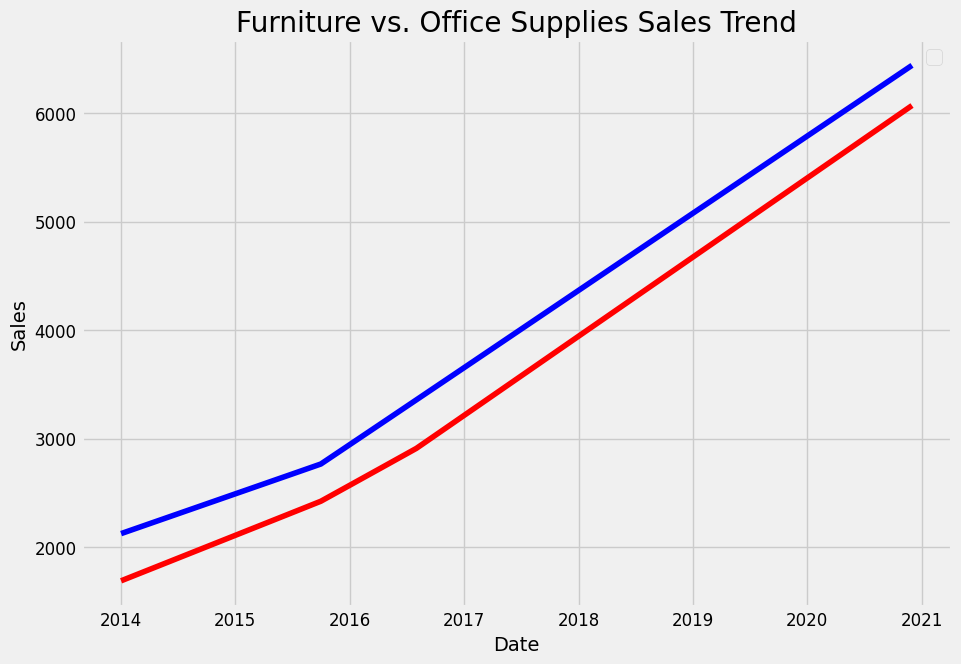

In [114]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

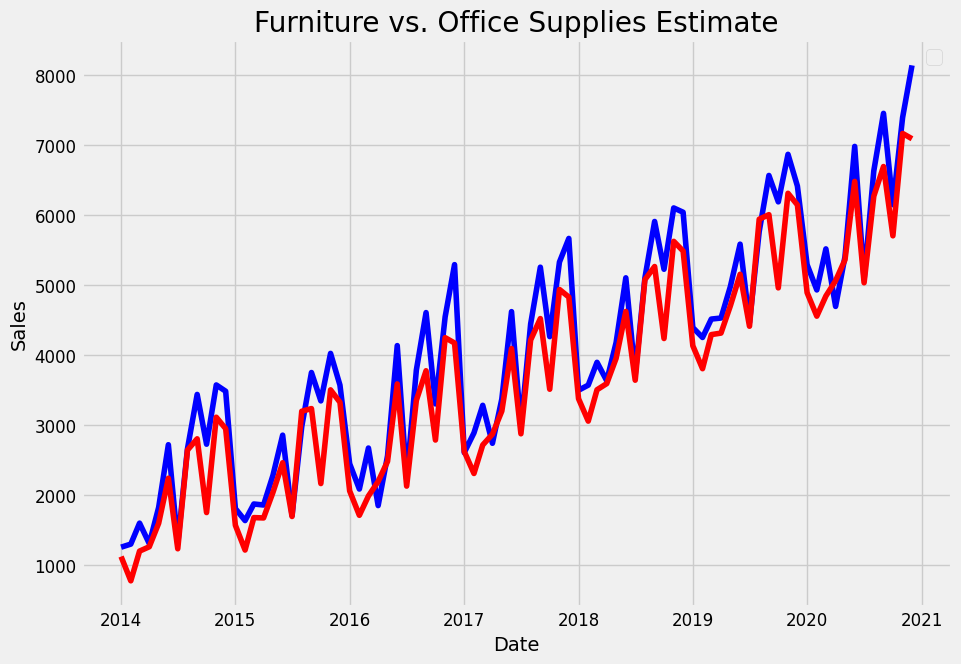

In [115]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

### Trends and Patterns

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

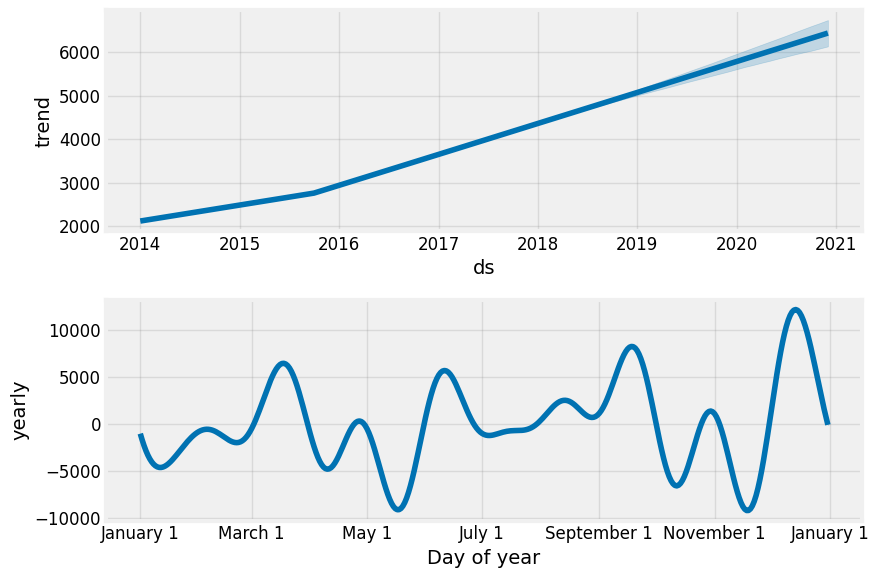

In [116]:
furniture_model.plot_components(furniture_forecast);

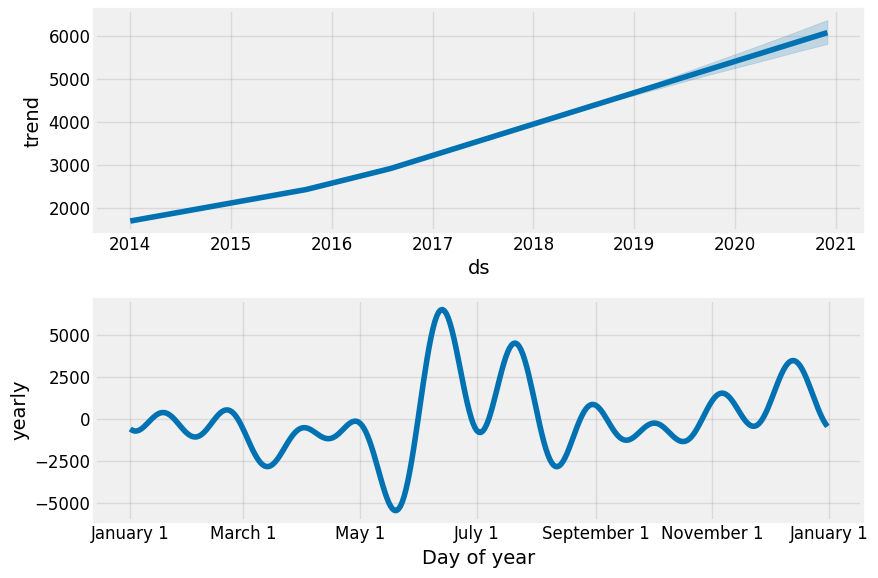

In [117]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time although office supplies' growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is November.

There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only scratched the surface here. Stay tuned for future works on time-series analysis.